<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025_Lab2-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zad 1.

Wyobraź sobie, że budujesz system monitorowania dla zakładu produkcyjnego. Czujniki zbierają dane, aby określić, czy maszyna działa prawidłowo, czy też wystąpiła awaria. Chociaż rzeczywiste dane z czujników są złożone, zasymulujemy je za pomocą syntetycznego zbioru danych "two-moons", który zawiera klasy nierozdzielne liniowo.

Twoim zadaniem jest zbudowanie wielowarstwowej sieci typu MLP do klasyfikacji wyników pomiarów.

Wskazówki:
- Zbuduj wielowarstwowy perceptron (MLP) z co najmniej dwiema warstwami ukrytymi.  
- Podziel dane na zbiór testowy oraz treningowy
- Wytrenuj model, używając odpowiedniej do problemu funckji straty.  

Szablon rozwiązania podany jest poniżej.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fikcyjne dane pomiarowe
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Wykres
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20, edgecolor='k')
plt.title("Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# TODO: podział danych na zb. treningowy oraz testowy

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # TODO: Warstwy sieci

    def forward(self, x):
        # TODO: Obliczenia fazy "w przód"
        return torch.zeros_like(x[-1])

model = MLP()

# Trening
for epoch in range(100):
    # TODO

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")


# Ewaluacja modelu
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")


# Wykres poprawnie / niepoprawnie sklasyfikowanych punktów danych
with torch.no_grad():
    correct_idx = (y_pred_class == y_test).view(-1).numpy()
    misclassified_idx = (y_pred_class != y_test).view(-1).numpy()
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy().flatten()

plt.figure(figsize=(8, 6))
# Poprawna klasyfikacja -- kolor szary
plt.scatter(X_test_np[correct_idx, 0], X_test_np[correct_idx, 1],
            c='lightgray', label='Correctly Classified', s=50, edgecolor='k')
# Błędna -- kolor czerwony
plt.scatter(X_test_np[misclassified_idx, 0], X_test_np[misclassified_idx, 1],
            c='red', label='Misclassified', s=50, edgecolor='k')
plt.legend()
plt.show()

# Zad. 2.

Opracuj model prognozujący liczbę dziennych wypożyczeń rowerów w systemie Capital Bikeshare (Waszyngton, D.C.) na podstawie danych historycznych zawartych w zbiorze "Daily Bike Rentals" z UCI Machine Learning Repository. Wartość docelowa to liczba wypożyczeń rowerów na dzień (kolumna **cnt**), która jest nieujemną liczbą całkowitą i podąża za rozkładem [rozkładem Poissona](https://pl.wikipedia.org/wiki/Rozk%C5%82ad_Poissona)

Zbiór danych zawiera 731 dziennych obserwacji z cechami takimi jak: temperatura (**temp**), wilgotność (**hum**), prędkość wiatru (**windspeed**), pora roku (**season**), warunki pogodowe (**weathersit**) oraz zmienne związane z datą (np. **yr**, **mnth**, **weekday**).


Wskazówki:

* Zaimplementuj funkcję straty:
$$L = \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \log(\hat{y}_i) \right)$$
gdzie:
$\hat{y}_i$ jest wart. predykowaną a $y_i$ prawdziwą.

* Zastosuj sieć MLP z 2 warstwami ukrytymi

* Ponieważ przewidywane liczby wypożyczeń muszą być nieujemne, należy zastosować funkcję aktywacji **Softplus** w warstwie wyjściowej MLP.

* Jakich zmian należy dokonać, żeby móc zastosować `torch.nn.PoissonNLLLoss` -- zmodyfikuj implementację i sprawdź działanie

## Przygotowanie danych

In [ ]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
!wget -O data.zip $url
!unzip -f data.zip

df = pd.read_csv("day.csv")
target = df["cnt"]
features = df.drop(columns=["cnt", "instant", "dteday"])  # Odrzuć ID oraz datę

In [ ]:
features

## Szkic rozwiązania

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = features.values
y = target.values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Podział na zb. treningowy i testowy
# TODO

# Normalizacja wartości
# TODO

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

    def forward(self, x):
        return torch.zeros_like(x[-1])

def poisson_loss(pred, target):
    return (pred - target * torch.log(pred + 1e-8)).mean()

model = MLP()

for epoch in range(1000):

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

# Ocena
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = nn.MSELoss()(y_pred, y_test)
    print(f"Błąd MSE: {mse.item():.4f}")

    # Predykcje vs rzeczywiste wartości
    print("Przykładowe predykcje vs rzeczywiste wart.:")
    for i in range(10):
        print(f"Pred: {y_pred[i].item():.2f}, True: {y_test[i].item()}")

# Przykład -- model dwuzadaniowy

Poniższy przykład ilustruje w jaki sposób możemy tworzyć i trenować modele
**wielozadaniowe**, np. regresja + klasyfikacja.

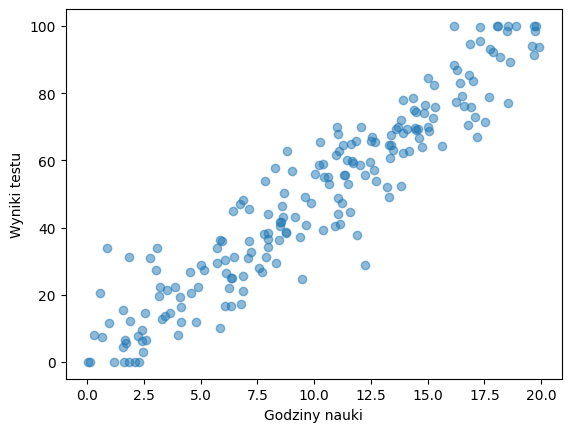

In [ ]:
# Generujemy dane do regresji -- czas nauki a wyniki na teście

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generowanie danych syntetycznych
np.random.seed(123)
N = 200  # liczba studentów

hours_studied = np.random.uniform(0, 20, N)
test_scores = 5 * hours_studied + np.random.normal(0, 10, N)  # wynik z szumem
test_scores = np.clip(test_scores, 0, 100)  # zakres wyników 0-100
passed = (test_scores >= 50).astype(int)

# Wykres
plt.scatter(hours_studied, test_scores, alpha=0.5)
plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.show()

Teraz dodajmy podział na **klasy**:
- *zdał* -- dla >= 50 pkt.
- *oblał* -- dla < 50 pkt.

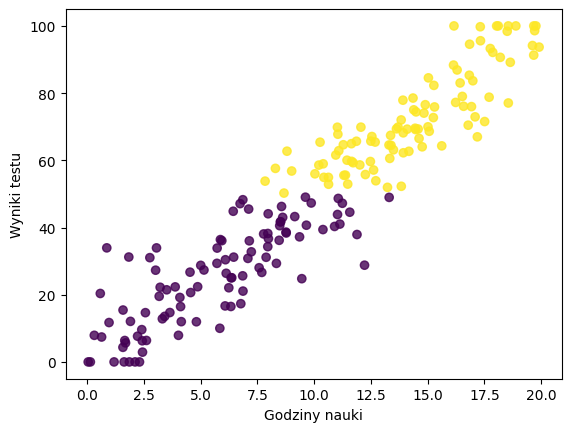

In [ ]:
passed = (test_scores >= 50).astype(int)

# Podział danych
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    hours_studied.reshape(-1,1), test_scores, passed, test_size=0.2, random_state=42
)

# Wykres
plt.scatter(hours_studied, test_scores, c=passed, alpha=0.8)
plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.show()

Na tej podstawie możemy zbudować zbiór danych dla naszego dwuzadaniowego modelu.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Podział danych
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    hours_studied.reshape(-1,1), test_scores, passed,
    test_size=0.2
)

# Dane możemy opakować w klasę StudentDataset dla wygody korzystania
# z treningu grupami (batch)

class StudentDataset(Dataset):
    def __init__(self, X, y_reg, y_cls):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_reg = torch.tensor(y_reg, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Dla każdego X zwracamy wynik regresji oraz klasę
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]


train_ds = StudentDataset(X_train, y_reg_train, y_cls_train)
test_ds = StudentDataset(X_test, y_reg_test, y_cls_test)

# Porcje po 16 elementów
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# Podgląd
for X_batch, y_reg_batch, y_cls_batch in train_loader:
    print(X_batch.shape, y_reg_batch.shape, y_cls_batch.shape)
    for hours, score, cls in zip(X_batch, y_reg_batch, y_cls_batch):
        print(f'{hours = } {score = } {cls = }')
    break

torch.Size([16, 1]) torch.Size([16]) torch.Size([16])
hours = tensor([12.6880]) score = tensor(65.4359) cls = tensor(1.)
hours = tensor([2.7683]) score = tensor(31.0319) cls = tensor(0.)
hours = tensor([15.6200]) score = tensor(64.3025) cls = tensor(1.)
hours = tensor([14.6215]) score = tensor(66.5158) cls = tensor(1.)
hours = tensor([2.1182]) score = tensor(0.) cls = tensor(0.)
hours = tensor([8.7643]) score = tensor(38.6344) cls = tensor(0.)
hours = tensor([8.5669]) score = tensor(46.2611) cls = tensor(0.)
hours = tensor([13.2313]) score = tensor(51.9543) cls = tensor(1.)
hours = tensor([16.7849]) score = tensor(70.4608) cls = tensor(1.)
hours = tensor([8.5166]) score = tensor(41.7178) cls = tensor(0.)
hours = tensor([12.4981]) score = tensor(65.7161) cls = tensor(1.)
hours = tensor([17.5091]) score = tensor(71.5413) cls = tensor(1.)
hours = tensor([9.8737]) score = tensor(47.3019) cls = tensor(0.)
hours = tensor([17.8678]) score = tensor(92.1257) cls = tensor(1.)
hours = tensor([9.1

Epoch 20, Loss: 77.8915
Epoch 40, Loss: 76.9059
Epoch 60, Loss: 75.1081
Epoch 80, Loss: 74.6630
Epoch 100, Loss: 74.2441

Regresja - MAE: 8.35
Klasyfikacja - dokładność: 0.90


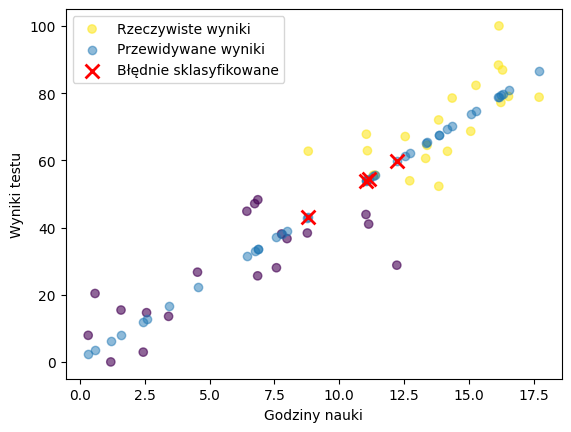

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        backbone_output_size = 10
        # Część wspólna (kręgosłup modelu, ang. backbone)
        self.shared = nn.Sequential(
            nn.Linear(1, backbone_output_size),
            nn.ReLU()
        )
        # Głowice modelu -- po jednej dla zadania.
        # Wejściem głowicy jest wynik części wspólnej

        # Głowica dla regresji
        self.regression = nn.Linear(backbone_output_size, 1)

        # Głowica dla klasyfikacji
        self.classification = nn.Sequential(
            nn.Linear(backbone_output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        shared_out = self.shared(x)  # wynik części wspólnej
        #                           / regresja     \ klasyfikacja
        #                          v                v
        return self.regression(shared_out), self.classification(shared_out)


# Trening
model = SimpleMultiTaskModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Uwaga -- 2 funkcje straty, bo 2 zadania:
reg_loss_fn = nn.MSELoss()
cls_loss_fn = nn.BCELoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for X_batch, y_reg_batch, y_cls_batch in train_loader:
        optimizer.zero_grad()

        reg_pred, cls_pred = model(X_batch)

        reg_loss = reg_loss_fn(reg_pred.squeeze(), y_reg_batch)
        cls_loss = cls_loss_fn(cls_pred.squeeze(), y_cls_batch)
        loss = reg_loss + cls_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


# Ewaluacja
model.eval()
with torch.no_grad():
    reg_preds, cls_preds = model(torch.tensor(X_test, dtype=torch.float32))
    reg_preds = reg_preds.squeeze().numpy()
    cls_preds = (cls_preds.squeeze().numpy() > 0.5).astype(int)

# Błąd regresji, tj. MAE (ang. Mean Abs. Error)
reg_mae = np.mean(np.abs(reg_preds - y_reg_test))
# Dokładność klasyfikacji
cls_accuracy = np.mean(cls_preds == y_cls_test)

print(f"\nRegresja - MAE: {reg_mae:.2f}")
print(f"Klasyfikacja - dokładność: {cls_accuracy:.2f}")

misclassified = y_cls_test != cls_preds

# Wizualizacja
plt.scatter(X_test, y_reg_test, c=y_cls_test, label='Rzeczywiste wyniki', alpha=0.6)
plt.scatter(X_test, reg_preds, label='Przewidywane wyniki', alpha=0.5)

plt.scatter(X_test[misclassified], reg_preds[misclassified], c='red', marker='x', s=100,
            label='Błędnie sklasyfikowane', linewidths=2)

plt.xlabel('Godziny nauki')
plt.ylabel('Wyniki testu')
plt.legend()
plt.show()


# Zad. 3.

Jako analityk danych edukacyjnych próbujesz jednocześnie przewidzieć wyniki (oceny) uczniów oraz ich aktywność pozalekcyjną. Twój model ma **dwa cele**, bazujące na demograficznych, społecznych i szkolnych atrybutach ucznia:

1. **Zadanie regresji:** Przewidywanie końcowego wyniku egzaminu ucznia (wartość ciągła w zakresie od 0 do 100).  
2. **Zadanie klasyfikacji:** Przewidywanie, czy uczeń uczestniczy w zajęciach pozalekcyjnych (`1`: tak, `0`: nie).

Na podstawie powyższego przykładu wytrenuj model typu MLP rozwiązujący postawiony problem.

Zbiorem danych jest
[UCI Machine Learning Repository - Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance):
  - Zawiera rzeczywiste dane uczniów z dwóch portugalskich szkół.  
  - Cechy obejmują atrybuty demograficzne (wiek, płeć), kontekst społeczny (wielkość rodziny, wykształcenie rodziców, relacje rodzinne), tło akademickie (wcześniejsze oceny, nieobecności) oraz atrybuty behawioralne (udział w zajęciach pozalekcyjnych, spożycie alkoholu).  
  - Zmienne docelowe:  
    - **Końcowa ocena (G3):** Ciągła wartość numeryczna reprezentująca końcowy wynik egzaminu (0-20, skalowana do 0-100).  
    - **Udział w zajęciach pozalekcyjnych:** Wskaźnik binarny (`tak`/`nie`), dostępny bezpośrednio w zbiorze danych.


**Wskazówki**:
- Podziel dane w stosunku `80/20` na zb. treningowy oraz testowy
- Sprawdź model z 1 oraz 2 warstwami ukrytymi oraz liczbą neuronów <= 100 w warstwie
- Liczba epok <= 500
- Czy możemy wpłynąć na wynik treningu, jeżeli wartość straty części regresyjnej przemnożymy, np. przez 10 zmieniając *wagę* tego zadania?


**Dodatkowo**:

Wytrenuj dwa odrębne modele, z których jeden dokonuje klasyfikacji a drugi regresji i porównaj wyniki z pierwotnym modelem.

Czy wyniki wskazują na korelację pomiędzy wynikami w nauce a udziałem w zajęciach pozalekcyjnych?

## Pobranie danych

In [ ]:
import pandas as pd
import requests
import zipfile
import io
from sklearn.preprocessing import StandardScaler

def load_data(url, file_name):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open(file_name) as f:
            df = pd.read_csv(f, sep=';')
    return df

# Przetwarzanie wstępne danych:
# - Skaluj ocenę końcową 'G3' do 0-100.
# - Mapuj 'activities' na wartości binarne.
# - Usuń pośrednie oceny i zakoduj pozostałe cechy metodą one-hot.
# - Standaryzuj cechy.
def preprocess_data(df):
    y_reg = df['G3'] * 5
    y_cls = df['activities'].map({'yes': 1, 'no': 0})

    X = df.drop(['G1', 'G2', 'G3'], axis=1)

    display(X[:3])

    X = pd.get_dummies(X)  # Cechy kategoryczne na one-hot
    display('Po kodowaniu one-hot:', X[:3])

    X_scaled = StandardScaler().fit_transform(X)
    display('Finalnie:', X_scaled[:3])
    return X_scaled, y_reg, y_cls


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
file_name = 'student-mat.csv'
df = load_data(url, file_name)
X, y_reg, y_cls = preprocess_data(df)